# A 1D convolutional net in Keras
Very little preprocessing was needed. Batch normalization made a huge difference, and made it possible to achieve perfect classification within the Kaggle kernel.

In [1]:
#We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

In [2]:
#Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


## Load the data

As the data format is so simple, we do not need pandas.

In [22]:
INPUT_LIB = 'data/'
raw_data = np.loadtxt(INPUT_LIB + 'ExoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.

x_test = np.vstack((x_train[:12, :], x_train[3500:, :]))
x_train = x_train[12:3500, :]
y_test = np.vstack((y_train[:12, :], y_train[3500:, :]))
y_train = y_train[12:3500, :]

# raw_data = np.loadtxt(INPUT_LIB + 'ExoTest.csv', skiprows=1, delimiter=',')
# x_test = raw_data[:, 1:]
# y_test = raw_data[:, 0, np.newaxis] - 1.
# print raw_data.shape
del raw_data
print 'Train data shape: '+str(x_train.shape)
print 'Test data shape: '+str(x_test.shape)

Train data shape: (3488, 3197)
Test data shape: (3488, 1)


Scale each observation to zero mean and unit variance.

In [23]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
           np.std(x_test, axis=1).reshape(-1,1))
print x_train.shape
print x_test.shape

(3488, 3197)
(472, 3197)


This is our only preprocessing step: We add an input corresponding to the running average over
200 time steps. This helps the net ignore high frequency noise and instead look at non-local
information. Look at the graphs below to see what it does.

In [24]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)
print x_train.shape
print x_test.shape

(3488, 3197, 2)
(472, 3197, 2)


In [ ]:
def residual_block(input_layer, output_channels, is_training, stride=1, first_block=False, name=None, reuse=False):
    """
 a residual block
 of operations include : 
    -> bactch_norm
-> relu
		-> conv
	"""
	if name is None:
		name = "residual_block"

	input_channels = input_layer.get_shape().as_list()[-2]
	with tf.variable_scope(name, reuse=reuse):
		# First conv block 
		with tf.variable_scope("block_1"):
			conv1_bn = batch_normalize(input_layer, is_training, reuse=reuse)
			conv1_ac = relu(conv1_bn)
			conv1 = conv2d(conv1_ac, kernel=3, stride=stride, name="conv1", reuse=reuse)
		# Second conv block
		with tf.variable_scope("block_2"):
			conv2_bn = batch_normalize(conv1, is_training, reuse=reuse)
			conv2_ac = relu(conv2_bn)
			conv2 = conv2d(conv2_ac, kernel=3, stride=stride, name="conv2", reuse=reuse)
		if conv2.get_shape().as_list()[-1] != input_layer.get_shape().as_list()[-1]:
			raise ValueError('Output and input channels do not match')	  
		else:
			output = input_layer + conv2
		return output


## Train the model

With the Sequential API for Keras, we only need to add the layers one at a time. Each 1D convolutional layers corresponds to a local filter, and then a pooling layer reduces the data length by approximately a factor 4. At the end, there are two dense layers, just as we would in a typical image classifier. Batch normalization layers speed up convergence. 

In [25]:
model = Sequential()
print x_train.shape[1:]
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

(3197, 2)


The data here is extremely unbalanced, with only a few positive examples. To correct for this, I use the positive examples a lot more often, so that the net sees 50% of each over each bats. Also, I generate new examples by rotation them randomly in time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [26]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

The hyperparameters here are chosen to finish training within the Kernel, rather than to get optimal results. On a GPU, I might have chosen a smaller learning rate, and perhaps SGD instead of Adam. As it turned out, results were brilliant anyway.

In [27]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=1, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/5
99/99 [==============================] - 18s 185ms/step - loss: 1.0233 - acc: 0.4956 - val_loss: 0.7159 - val_acc: 0.4258
Epoch 2/5
99/99 [==============================] - 18s 181ms/step - loss: 0.8821 - acc: 0.5174 - val_loss: 0.6761 - val_acc: 0.6377
Epoch 3/5
99/99 [==============================] - 16s 162ms/step - loss: 0.8149 - acc: 0.5095 - val_loss: 0.6149 - val_acc: 0.7500
Epoch 4/5
99/99 [==============================] - 17s 177ms/step - loss: 0.7697 - acc: 0.5215 - val_loss: 0.5554 - val_acc: 0.8475
Epoch 5/5
99/99 [==============================] - 16s 165ms/step - loss: 0.7499 - acc: 0.5218 - val_loss: 0.5095 - val_acc: 0.9025


In [28]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40
 - 13s - loss: 0.7325 - acc: 0.5388 - val_loss: 0.4553 - val_acc: 0.9322
Epoch 2/40
 - 12s - loss: 0.7016 - acc: 0.5723 - val_loss: 0.4610 - val_acc: 0.9153
Epoch 3/40
 - 12s - loss: 0.6895 - acc: 0.5761 - val_loss: 0.4540 - val_acc: 0.9131
Epoch 4/40
 - 14s - loss: 0.6594 - acc: 0.6146 - val_loss: 0.4423 - val_acc: 0.8962
Epoch 5/40
 - 12s - loss: 0.6383 - acc: 0.6436 - val_loss: 0.4306 - val_acc: 0.8941
Epoch 6/40
 - 14s - loss: 0.6181 - acc: 0.6471 - val_loss: 0.4266 - val_acc: 0.8814
Epoch 7/40
 - 12s - loss: 0.6250 - acc: 0.6471 - val_loss: 0.4132 - val_acc: 0.8919
Epoch 8/40
 - 12s - loss: 0.6159 - acc: 0.6613 - val_loss: 0.3954 - val_acc: 0.8877
Epoch 9/40
 - 12s - loss: 0.5817 - acc: 0.6929 - val_loss: 0.3933 - val_acc: 0.8792
Epoch 10/40
 - 13s - loss: 0.5760 - acc: 0.6989 - val_loss: 0.3832 - val_acc: 0.8729
Epoch 11/40
 - 13s - loss: 0.5450 - acc: 0.7238 - val_loss: 0.3715 - val_acc: 0.8665
Epoch 12/40
 - 12s - loss: 0.5422 - acc: 0.7241 - val_loss: 0.3627 - val_a

#Evaluate the model

First we look at convergence

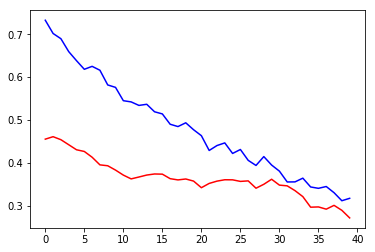

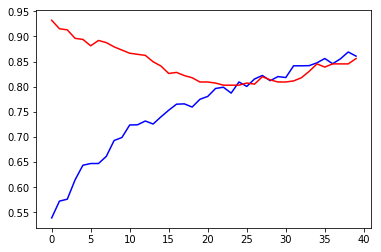

In [29]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

We then use our trained net to classify the test set.

In [30]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

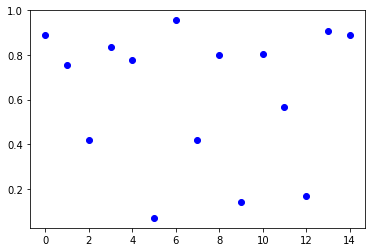

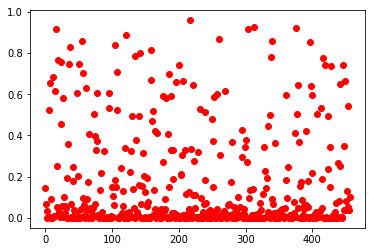

In [31]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Also, almost all negative examples get score close to zero, except a few in the 0.9-1.0 range. This is encouraging.

We now choose an optimal cutoff score for classification. Sklearn can help us with this.

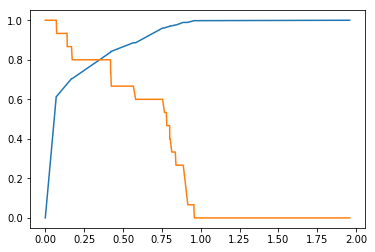

Crossover at 0.17 with specificity 0.70


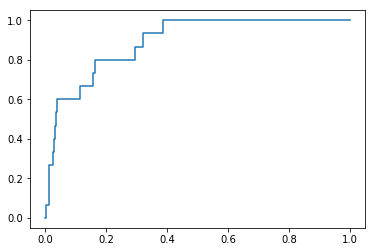

ROC area under curve is 0.89


In [32]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

Let's take a look at the misclassified data (if any):

17


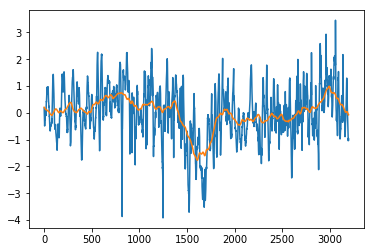

19


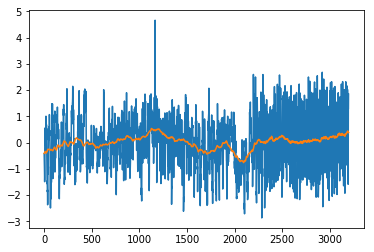

24


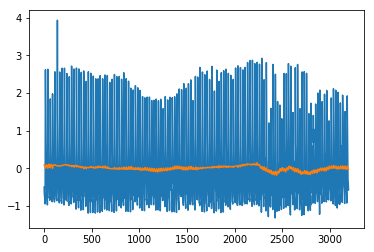

27


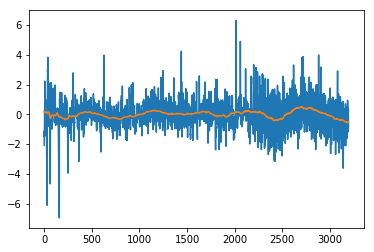

28


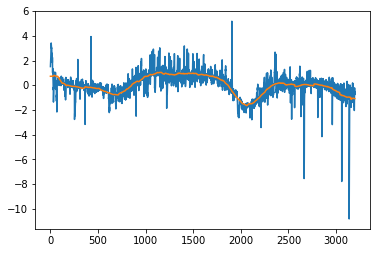

29


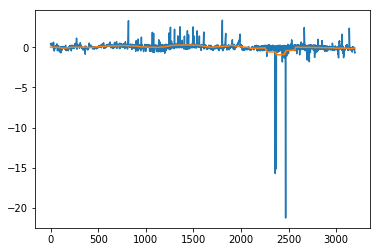

31


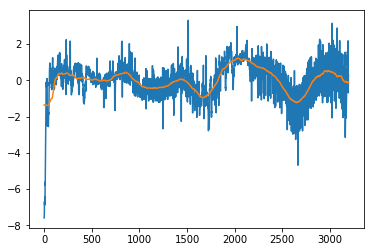

35


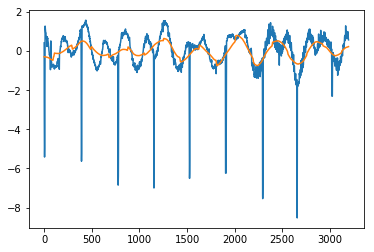

36


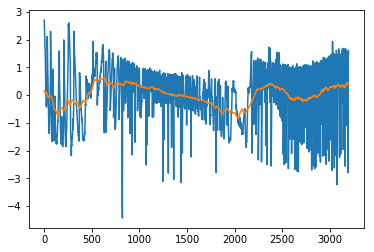

38


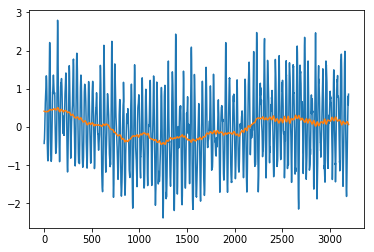

45


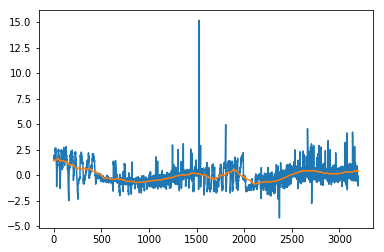

46


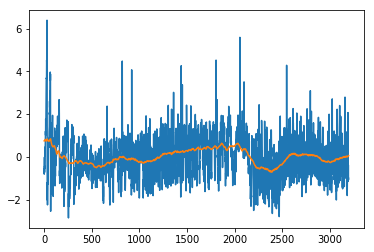

47


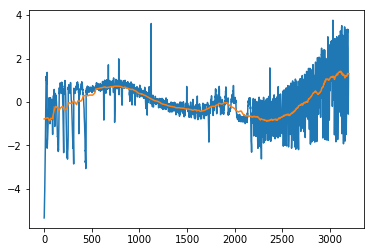

49


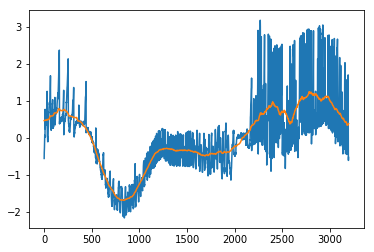

53


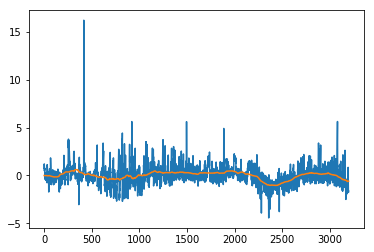

54


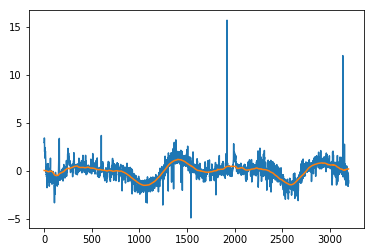

60


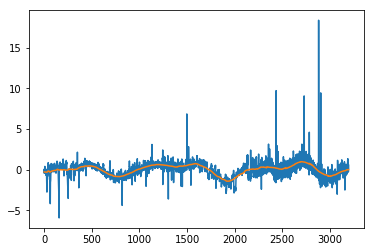

61


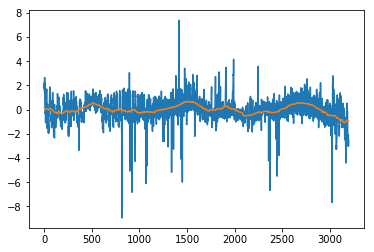

62


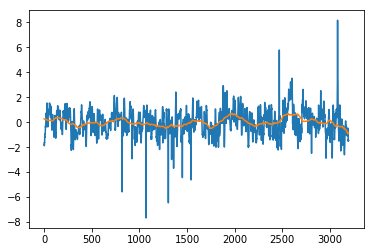

67


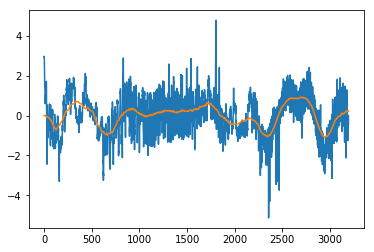

68


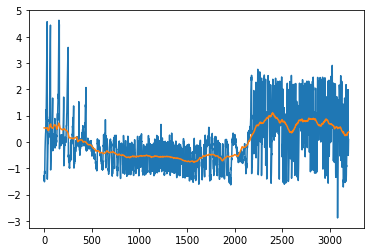

76


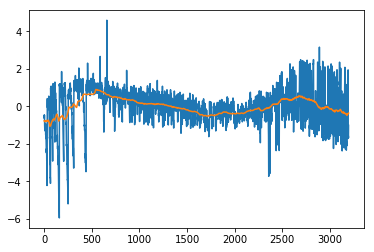

79


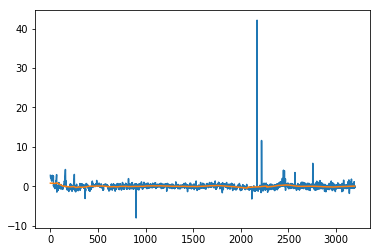

80


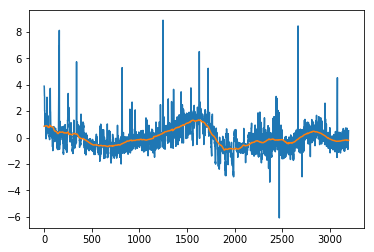

88


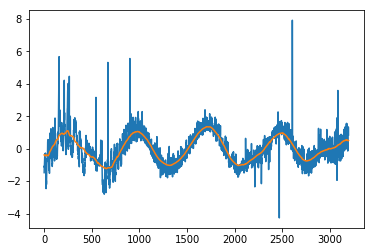

90


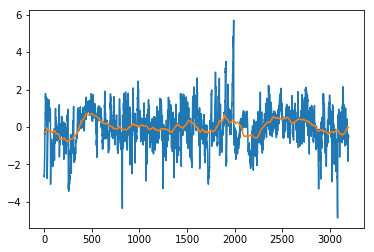

91


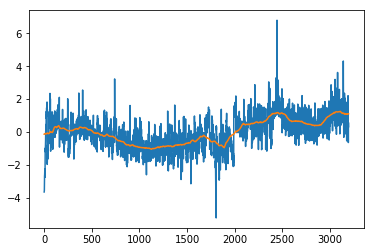

92


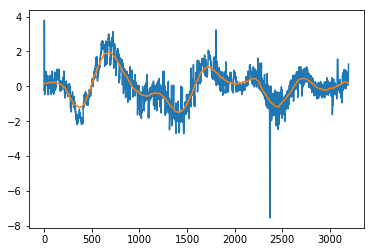

93


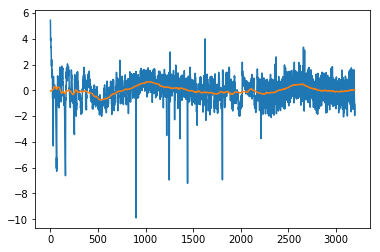

98


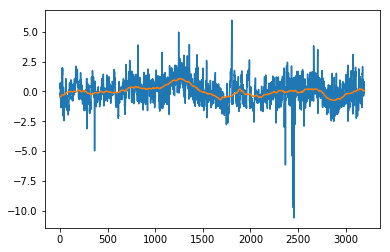

103


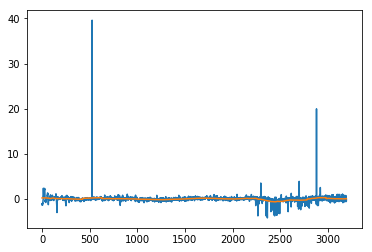

110


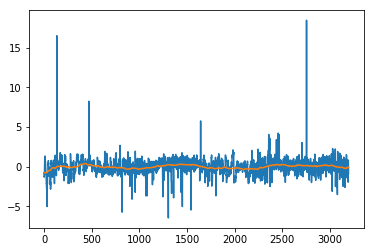

111


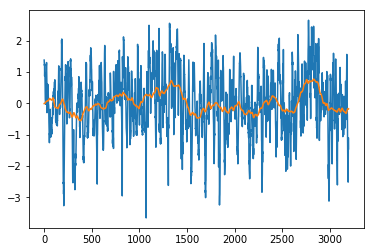

119


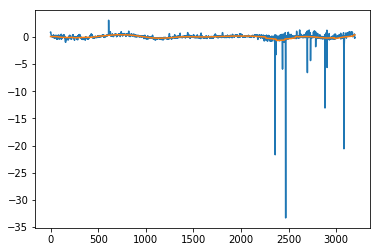

120


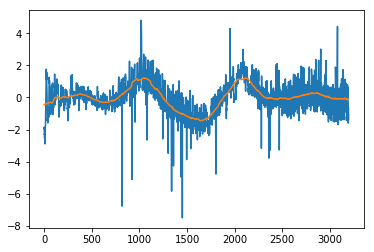

122


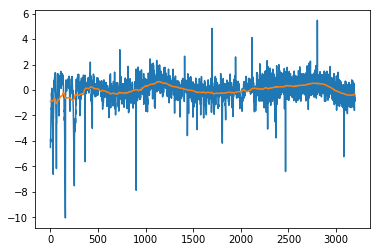

123


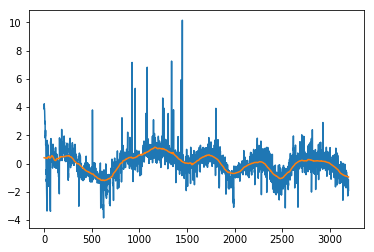

129


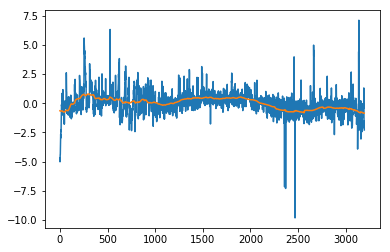

134


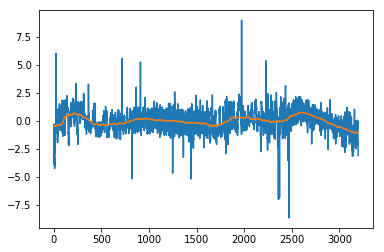

136


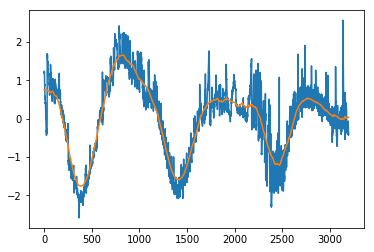

142


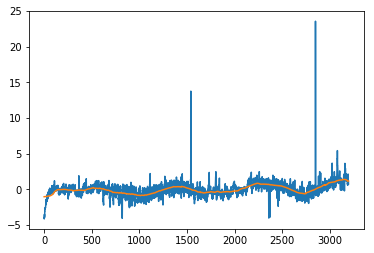

144


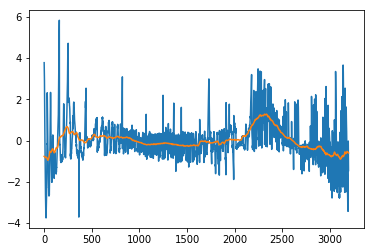

145


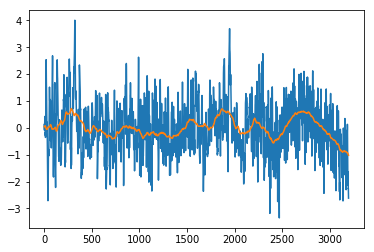

150


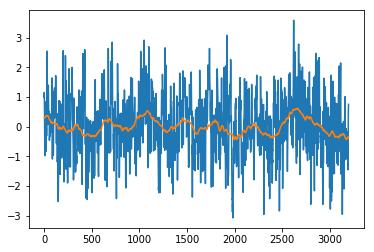

151


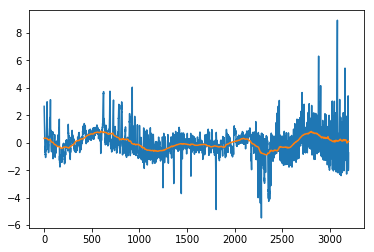

155


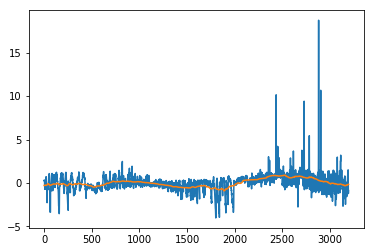

157


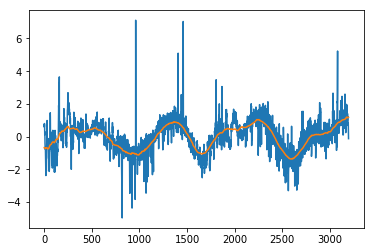

162


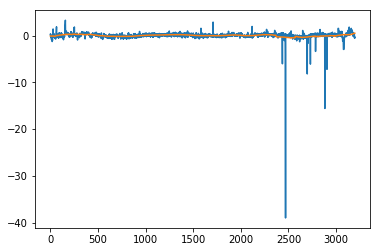

163


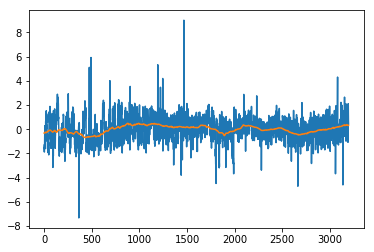

168


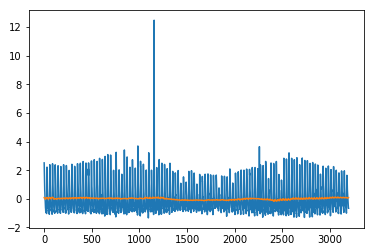

173


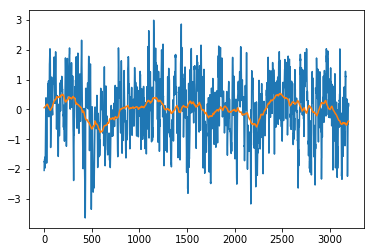

174


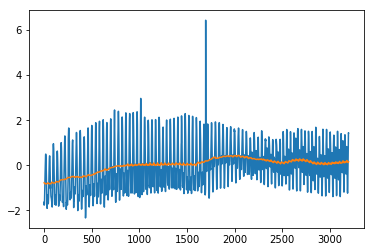

175


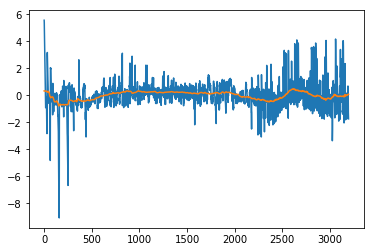

176


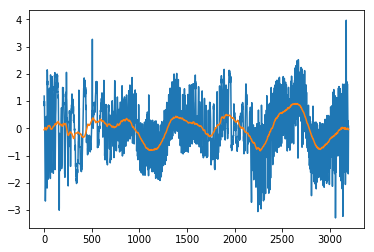

180


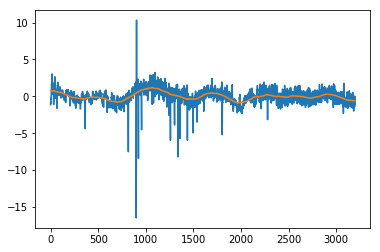

182


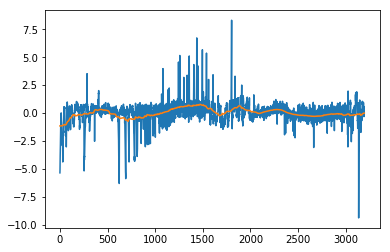

191


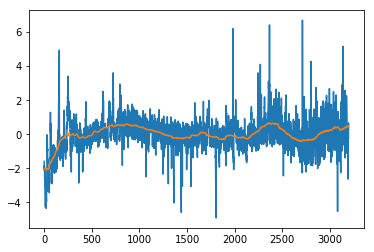

192


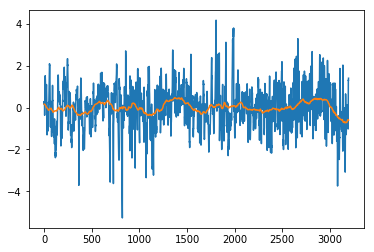

196


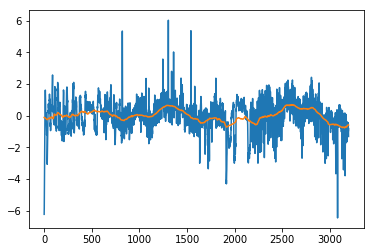

199


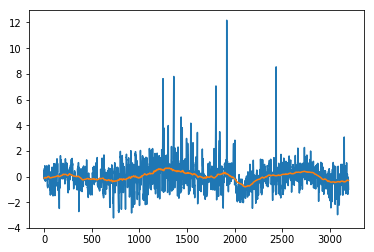

201


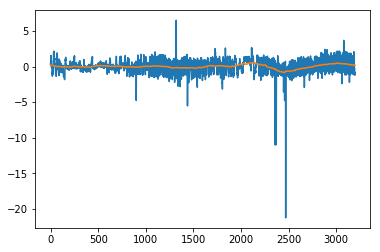

203


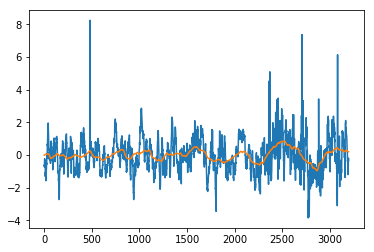

204


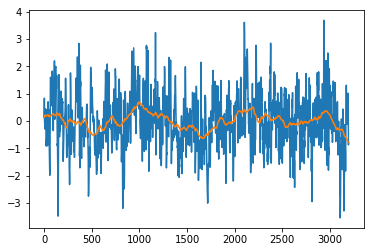

206


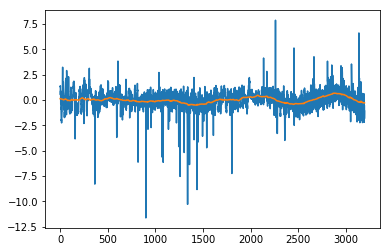

207


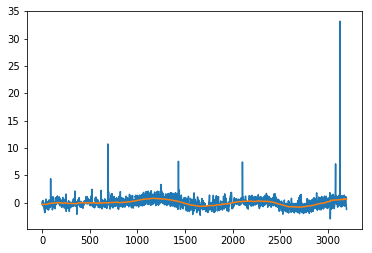

211


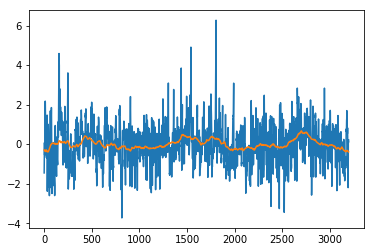

215


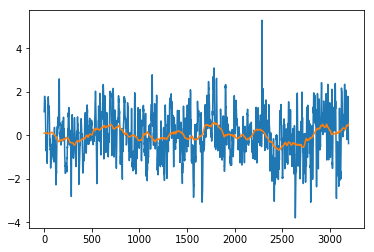

218


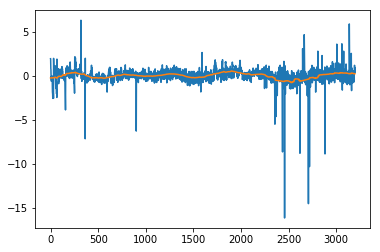

219


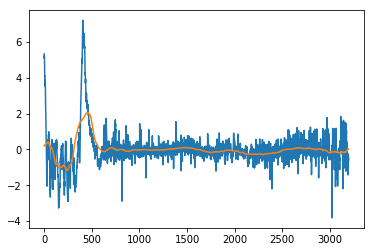

220


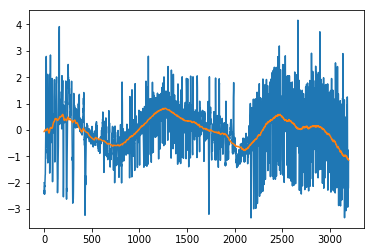

221


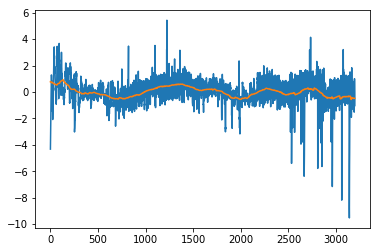

224


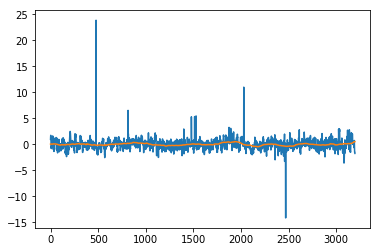

232


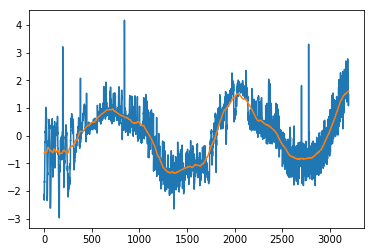

233


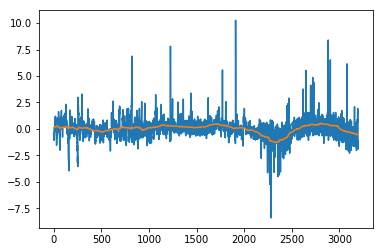

236


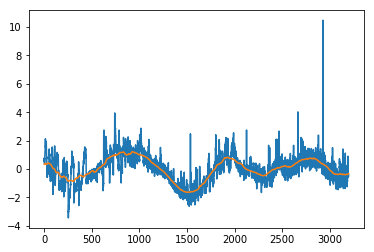

238


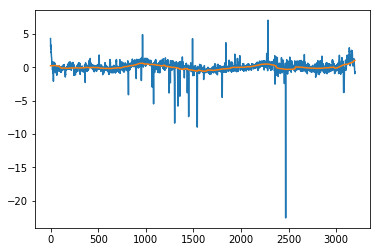

244


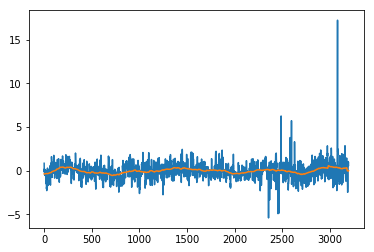

247


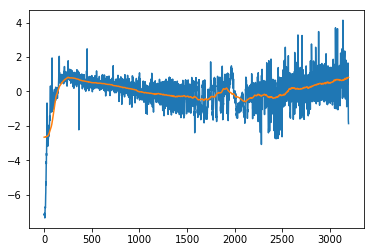

254


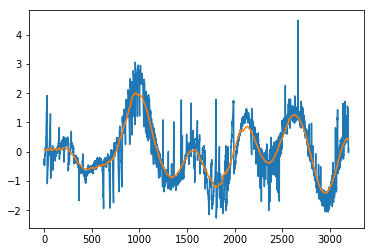

255


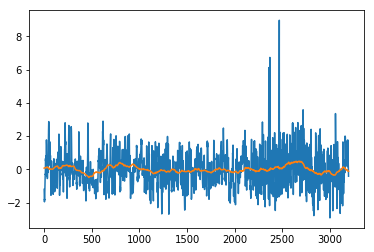

265


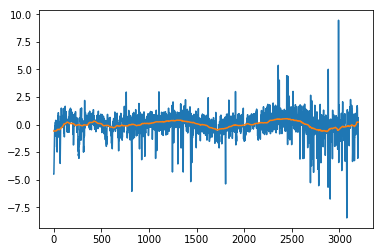

267


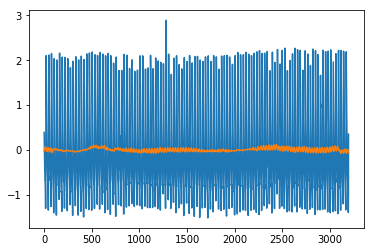

268


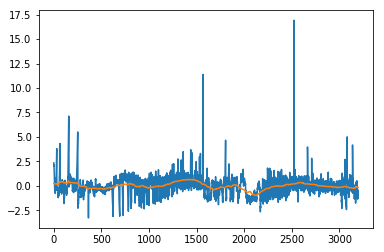

273


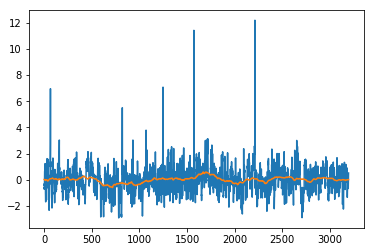

275


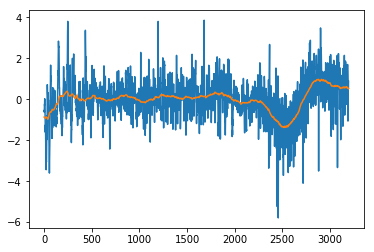

277


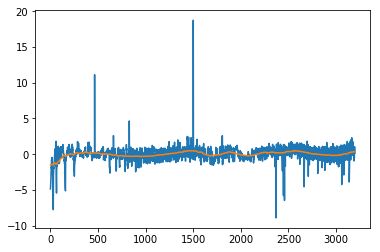

284


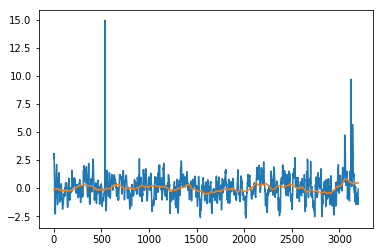

293


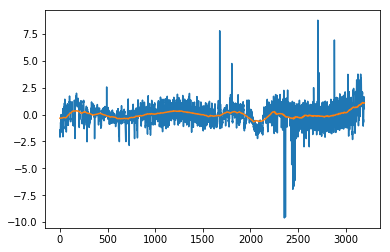

295


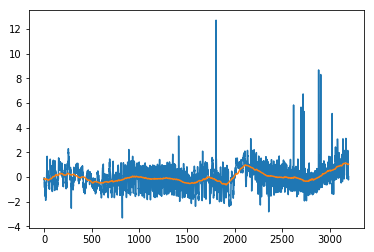

309


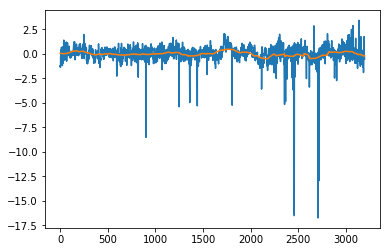

310


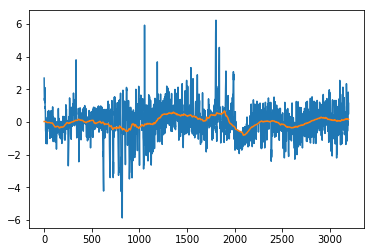

314


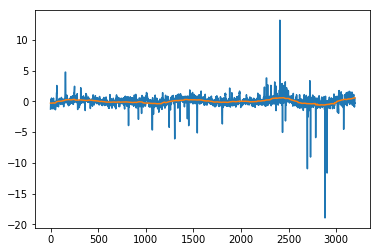

316


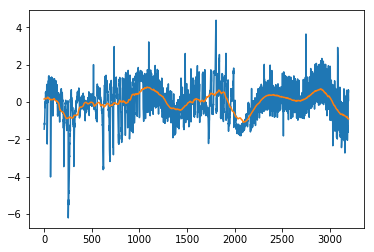

317


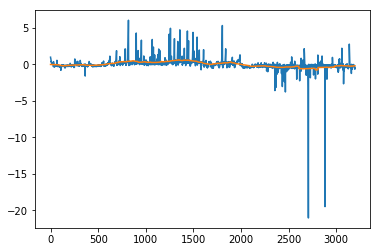

319


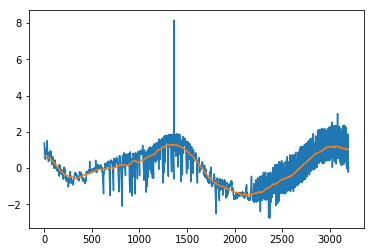

328


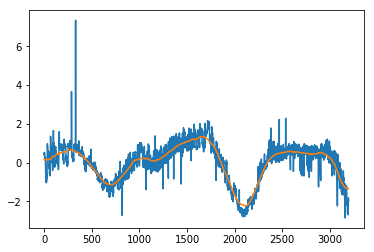

342


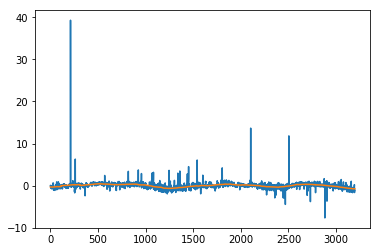

344


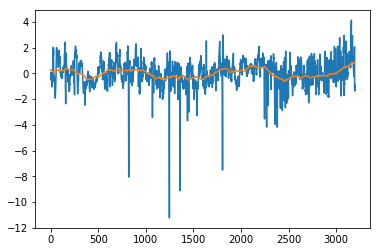

347


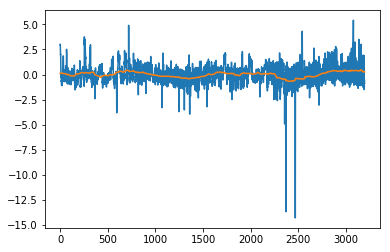

348


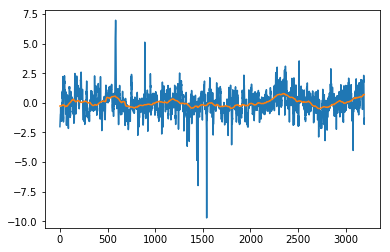

352


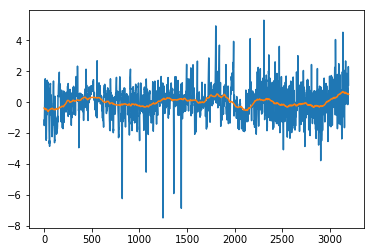

353


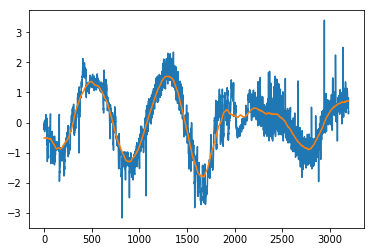

355


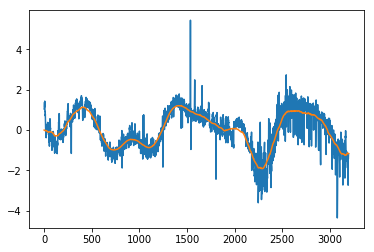

359


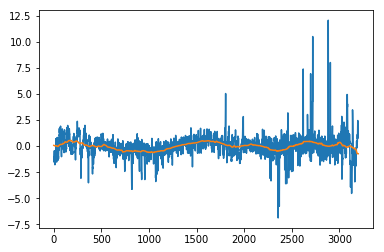

375


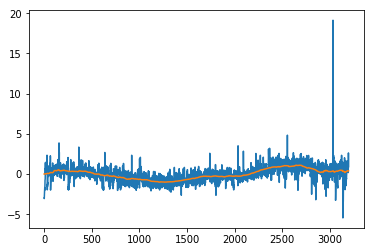

376


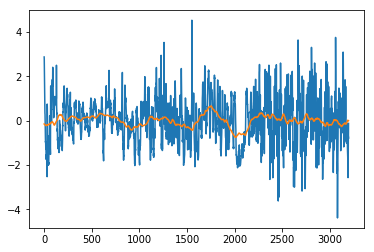

379


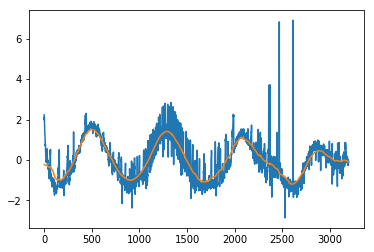

389


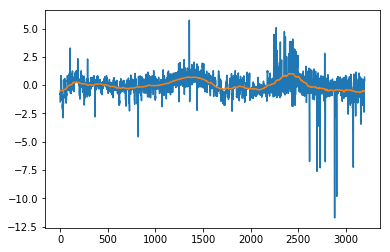

391


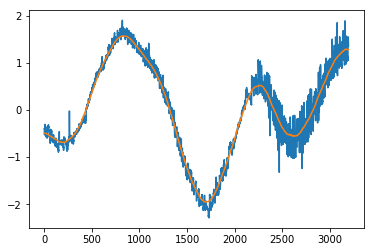

392


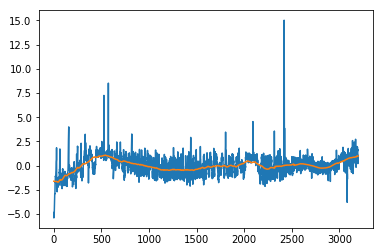

394


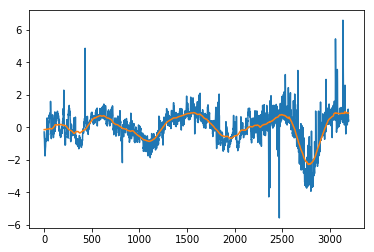

395


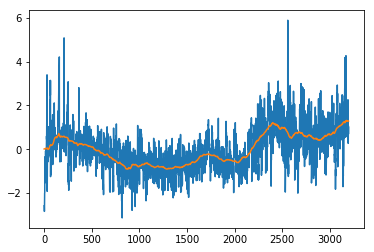

406


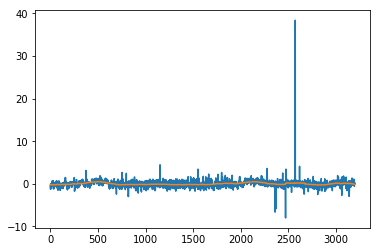

408


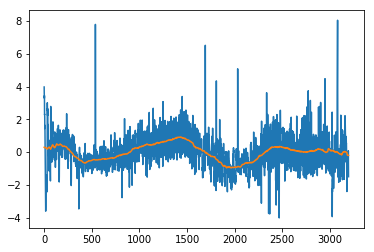

412


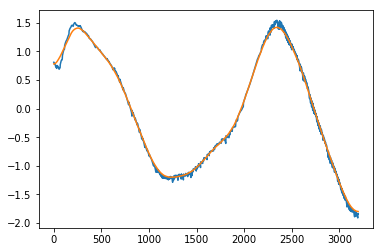

413


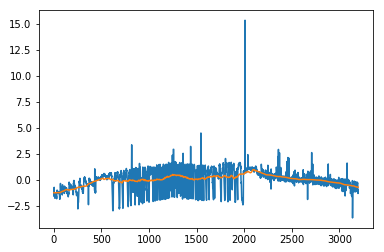

414


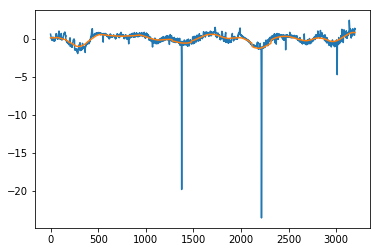

415


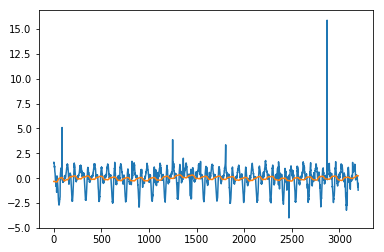

422


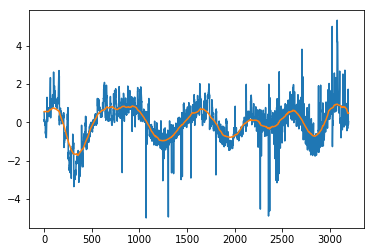

428


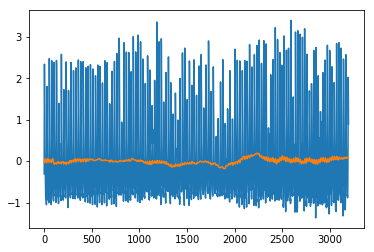

430


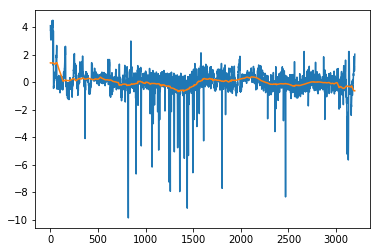

431


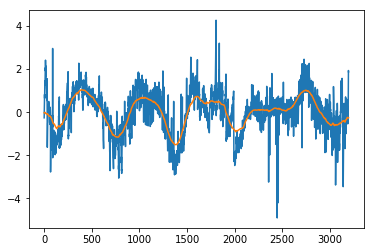

434


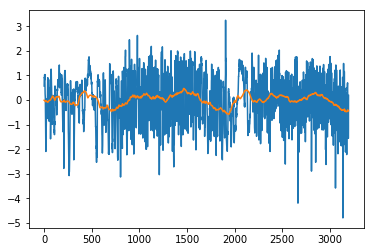

438


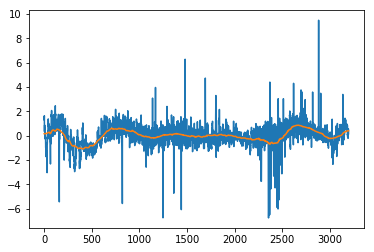

439


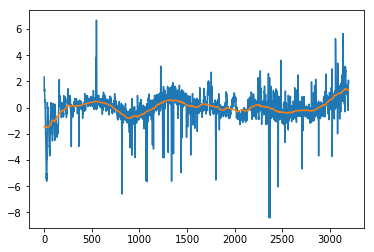

442


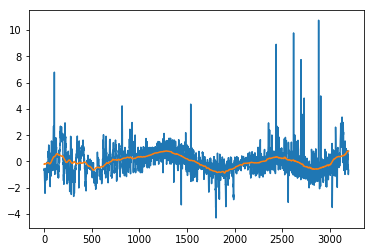

443


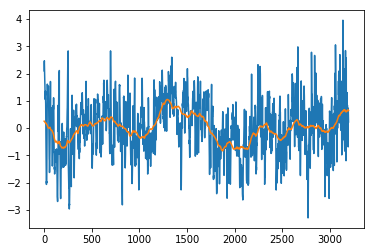

453


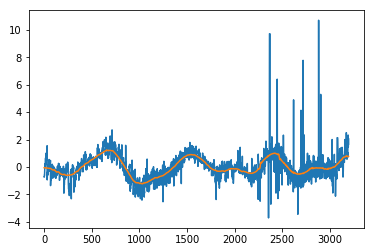

456


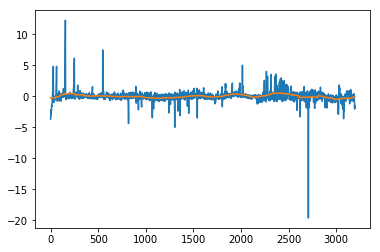

457


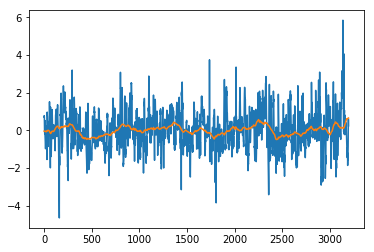

461


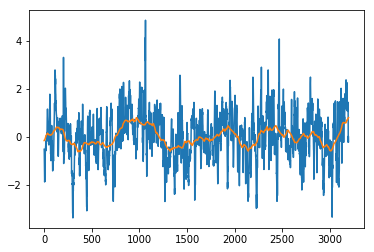

462


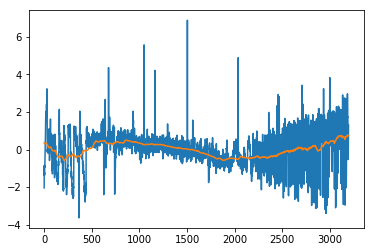

464


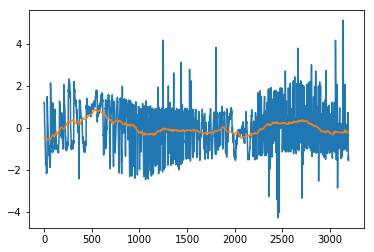

469


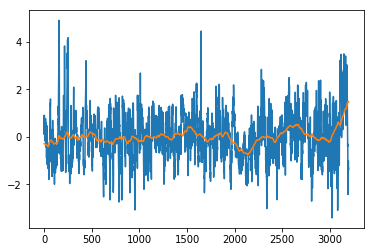

In [33]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

It seems NASA missed one planet. I take this opportunity to claim it, and hereby name it Kaggle alpha :)